# Recurrent Neural Network (LSTM)
###### TImeseries(climate) using tensorflow

Import dependencies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Pre-process data

In [2]:
# seed random number generators
np.random.seed(1)
tf.set_random_seed(1)

In [3]:
# Paramaters
seq_len = 50  # Sequence Length
train_test_ratio = 0.7

In [4]:
time_series = []  # float values in ppm
time_stamps = []  # string corresponding to year-month

read from data from csv file

In [5]:
with open('datasets/co2-ppm-mauna-loa-19651980.csv') as f:
    skipped_line = False
    for line in f.readlines():
        if not skipped_line:
            skipped_line = True
            continue
        else:
            try:
                line = line.strip().split(',')
                time_series.append([float(line[1])])
                time_stamps.append(line[0].strip('"'))
            except Exception as e:
                break

Scale data

In [6]:
ts_min = np.min(time_series)
ts_max = np.max(time_series)

time_series = (time_series - ts_min) / (ts_max - ts_min)

Split data into train and test

In [7]:
train_time_series = time_series[:int(len(time_series) * train_test_ratio)]
test_time_series = time_series[int(len(time_series) * train_test_ratio) - 1:]

Creates sequences from data

In [8]:
def create_dataset(data, len_seq):
    features = []
    labels = []
    for i in range(len(data) - len_seq):
        features.append(data[i:i + len_seq])
        labels.append(data[i + len_seq])
    return features, labels


trainX, trainY = create_dataset(train_time_series, seq_len)
testX, testY = create_dataset(np.concatenate((trainX[-1], test_time_series)), seq_len)

## Neural Network

hyper-parameters

In [9]:
n_rnn_neurons = 100
n_input_neurons = 1
n_output_neurons = 1

learn_rate = 0.006

n_epoch = 1000

input/output placeholders

In [10]:
X = tf.placeholder(tf.float32, [None, seq_len, n_input_neurons])
Y = tf.placeholder(tf.float32, [None, n_output_neurons])

Weights and biases for final fully connected layer

In [11]:
layer_op = {
    'weight':
        tf.Variable(tf.random_normal([n_rnn_neurons, n_output_neurons], stddev=1)),
    'bias':
        tf.Variable(tf.random_normal([n_output_neurons], stddev=1))
}

#### Model

In [12]:
# lstm + droput layer
cell = tf.contrib.rnn.BasicLSTMCell(n_rnn_neurons)
cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.75)
lstm_op, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# Just connect last output of hidden layer to fully connected layer
lstm_op = tf.squeeze(lstm_op[:,-1:], axis=1)
final_op = tf.nn.sigmoid(tf.matmul(lstm_op, layer_op['weight']) + layer_op['bias'])

#### Error and Optimizer

In [13]:
# mean-squared error
error = tf.reduce_mean(0.5 * tf.square(final_op - Y))

# adam-optimizer
optimizer = tf.train.AdamOptimizer(learn_rate).minimize(error)

#### Start Session

In [14]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    print("*********** Train ***********")

    for epoch in range(n_epoch):
        _, err = sess.run([optimizer, error], feed_dict={X: trainX, Y: trainY})

        if epoch % 100 == 0:
            print("Epoch : %d Error = %f" % (epoch, err))

    print("\n*********** Test ***********")

    err, resultt = sess.run([error, final_op], feed_dict={X: testX, Y: testY})
    print("Testing Error : %f" % err)
    
    # Predict futur values with continuous data
    inp = trainX[-1].flatten().tolist()
    resultp = []

    for i in range(len(test_time_series)):
        op = final_op.eval({X: np.reshape(inp, [1, -1, 1])})
        inp.append(op[0][0])
        resultp.append(op[0][0])
        del inp[0]

*********** Train ***********
Epoch : 0 Error = 0.019487
Epoch : 100 Error = 0.000682
Epoch : 200 Error = 0.000407
Epoch : 300 Error = 0.000357
Epoch : 400 Error = 0.000228
Epoch : 500 Error = 0.000277
Epoch : 600 Error = 0.000229
Epoch : 700 Error = 0.000218
Epoch : 800 Error = 0.000173
Epoch : 900 Error = 0.000175

*********** Test ***********
Testing Error : 0.001723


#### Plot test and prediction output

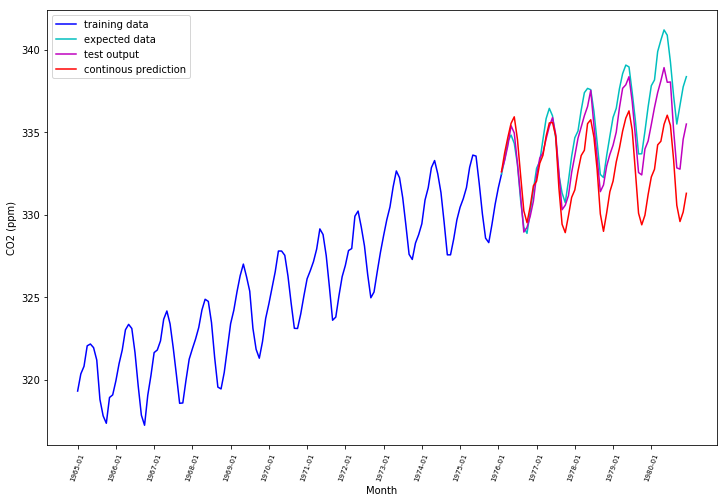

In [15]:
plt.figure(figsize=(12, 8))

plt.plot(
    train_time_series * (ts_max - ts_min) + ts_min,
    'b',
    label='training data')
plt.plot(
    np.arange(len(train_time_series) - 1, len(time_series)),
    test_time_series * (ts_max - ts_min) + ts_min,
    'c',
    label='expected data')
plt.plot(
    np.arange(len(train_time_series) - 1, len(time_series)),
    resultt * (ts_max - ts_min) + ts_min,
    'm',
    label='test output')
plt.plot(
    np.arange(len(train_time_series) - 1, len(time_series)),
    np.array(resultp) * (ts_max - ts_min) + ts_min,
    'r',
    label='continous prediction')

plt.xticks(
    np.arange(0, len(time_series), 12),
    time_stamps[::12],
    rotation=70,
    fontsize=7)
plt.xlabel('Month')
plt.ylabel('CO2 (ppm)')
plt.legend(loc='upper left')
plt.show()